In [2]:
import numpy as np

!pip install opencv-contrib-python==3.4.2.16
import cv2 as cv

import os

from collections import Counter

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


In [3]:

!wget --quiet http://www.cmpe.boun.edu.tr/pilab/pilabfiles/assignments/hw4-dataset.zip
!unzip hw4-dataset.zip
!ls

hw4-dataset.zip    hw4-dataset.zip.2  sample_data  train
hw4-dataset.zip.1  hw4-dataset.zip.3  test


In [0]:
sift = cv.xfeatures2d.SIFT_create(nfeatures=500)

def get_features(path):
    img = cv.imread(path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp = sift.detect(gray, None)
    kp, des = sift.compute(gray, kp)
    return des

In [0]:
sifts = []
correspounding_image_data = []
sep = os.path.sep
for root, dirs, files in os.walk("train", topdown=True):
    if dirs:
        class_names = dirs
        num_categories = len(dirs)
    if files:
        dir_name = root.split(sep)[-1]
        for fname in files:
            path = os.path.join(root, fname)
            features = get_features(path)
            sifts.append(features)
            # all_features.extend(features)
            correspounding_image_data.append((dir_name, fname, len(features)))


In [6]:
all_features = np.concatenate(sifts,axis=0)
print(all_features.shape)

(345423, 128)


In [0]:
def to_hist(counter, k):
    arr = np.array([counter[i] for i in range(k)],dtype=np.float)
    # default is l2 == normalize to unit length equivalent of arr/np.sqrt((arr**2).sum())
    # but chi square is usually used with l1 see https://scikit-learn.org/stable/modules/metrics.html#chi-squared-kernel
    return  normalize(arr.reshape(-1,1), norm='l1', axis=0).flatten()

In [8]:
k = 100
kmeans = KMeans(n_clusters = k)
kmeans.fit(all_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
train_imgs_with_hists = [] # dir_name==label, image_name, histogram==features
start = 0
for dn, fn, num in correspounding_image_data:
    ids = kmeans.labels_[start:start+num]
    train_imgs_with_hists.append((dn,fn,to_hist(Counter(ids),k)))
    start+=num
        
        

In [10]:
codewords = kmeans.cluster_centers_
len(codewords)

100

In [0]:
test_imgs_with_hists = [] # dir_name==label, image_name, histogram==features
sep = os.path.sep
for root, dirs, files in os.walk("test", topdown=True):
    if dirs:
        num_categories = len(dirs)
    if files:
        dir_name = root.split(sep)[-1]
        for fname in files:
            path = os.path.join(root, fname)
            features = get_features(path)
            labels_of_vectors = kmeans.predict(features)
            test_imgs_with_hists.append((dir_name, fname, to_hist(Counter(labels_of_vectors),k)))

In [0]:
y, _, X = zip(*train_imgs_with_hists) # zip trick, equivalent of :
# X = [x[2] for x in train_imgs_with_hists]
# y = [x[0] for x in train_imgs_with_hists]

In [13]:
parameters = {'kernel':( 'linear', 'rbf', chi2_kernel), 'C':list(range(1,15))}
svc = svm.SVC(gamma='scale')
grids = GridSearchCV(svc, parameters, cv=5, iid=False)
best_results = grids.fit(X, y)
best_results.best_params_

{'C': 5, 'kernel': <function sklearn.metrics.pairwise.chi2_kernel>}

In [14]:
clf = svm.SVC(kernel=chi2_kernel,C=5)
clf.fit(X, y)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel=<function chi2_kernel at 0x7f40695c9a60>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [15]:
trainin_score = clf.score(X,y)
print(trainin_score, 'k = ', k)

0.9789343246592317 k =  100


In [0]:
test_y, _, test_X = zip(*test_imgs_with_hists) # zip trick, equivalent of :

In [0]:
predictions = clf.predict(test_X)

In [18]:
acc= accuracy_score(test_y, predictions)
print(acc)

0.6428571428571429


In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.ylim([6.5, -.5])
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    

In [0]:
labels = sorted(class_names)

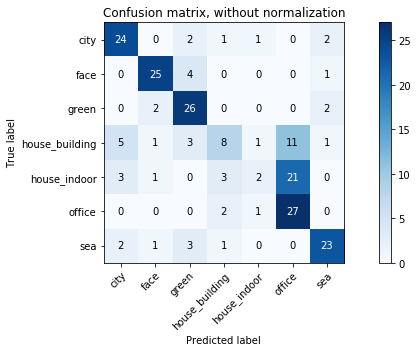

In [21]:
_ = plot_confusion_matrix(test_y, predictions, labels)